# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_residual'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model with residual connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        return x

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32, dropout_rate=0.25):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size

        # Encoder
        self.encoder = nn.Sequential(
            ResidualBlock(3, 32),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 64),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            ResidualBlock(128, 128),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 32),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters, calculate_metrics, save_to_file, load_from_file, print_matrix, plot_conf_matrix

def train_model(embedding_size=32, dropout_rate=0.25, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size, dropout_rate=dropout_rate)
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    metrics = calculate_metrics(model, testset)
    print_matrix(metrics)
    plot_conf_matrix(metrics['conf_matrix'])
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 832615
Epoch [1/20], Train Loss: 0.2546, Test Loss: 0.1641
Epoch [2/20], Train Loss: 0.1460, Test Loss: 0.1559
Epoch [3/20], Train Loss: 0.1361, Test Loss: 0.1460
Epoch [4/20], Train Loss: 0.1303, Test Loss: 0.1440
Epoch [5/20], Train Loss: 0.1264, Test Loss: 0.1432
Epoch [6/20], Train Loss: 0.1240, Test Loss: 0.1372
Epoch [7/20], Train Loss: 0.1204, Test Loss: 0.1333
Epoch [8/20], Train Loss: 0.1181, Test Loss: 0.1342
Epoch [9/20], Train Loss: 0.1159, Test Loss: 0.1293
Epoch [10/20], Train Loss: 0.1148, Test Loss: 0.1262
Epoch [11/20], Train Loss: 0.1139, Test Loss: 0.1238
Epoch [12/20], Train Loss: 0.1132, Test Loss: 0.1238
Epoch [13/20], Train Loss: 0.1125, Test Loss: 0.1250
Epoch [14/20], Train Loss: 0.1114, Test Loss: 0.1223
Epoch [15/20], Train Loss: 0.1107, Test Loss: 0.1207
Epoch [16/20], Train Loss: 0.1099, Test Loss: 0.1214
Epoch [17/20], Train Loss: 0.1095, Test Loss: 0.1225
Epoch [18/20], Train Loss: 0.1091, Test Loss: 0.1207
Epoch [19/20], Train Loss:

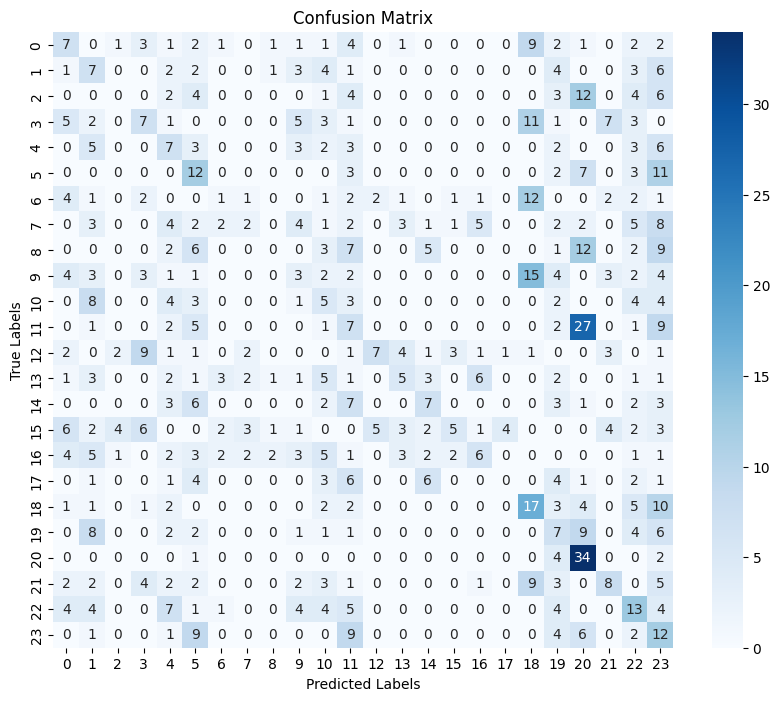

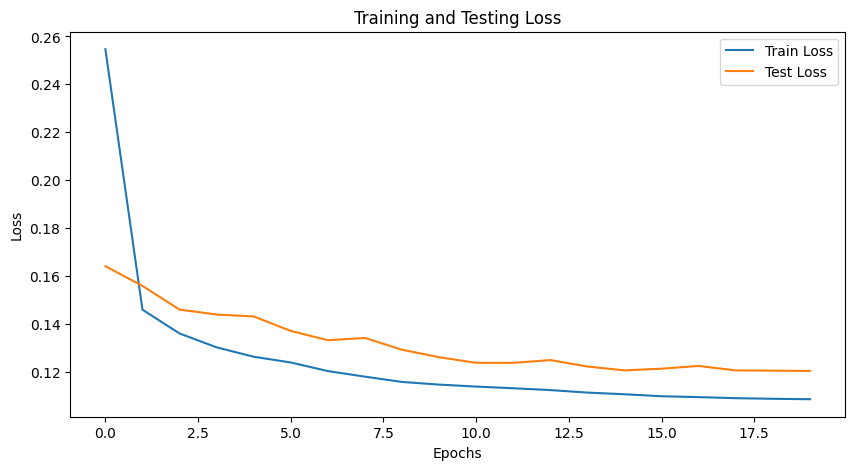

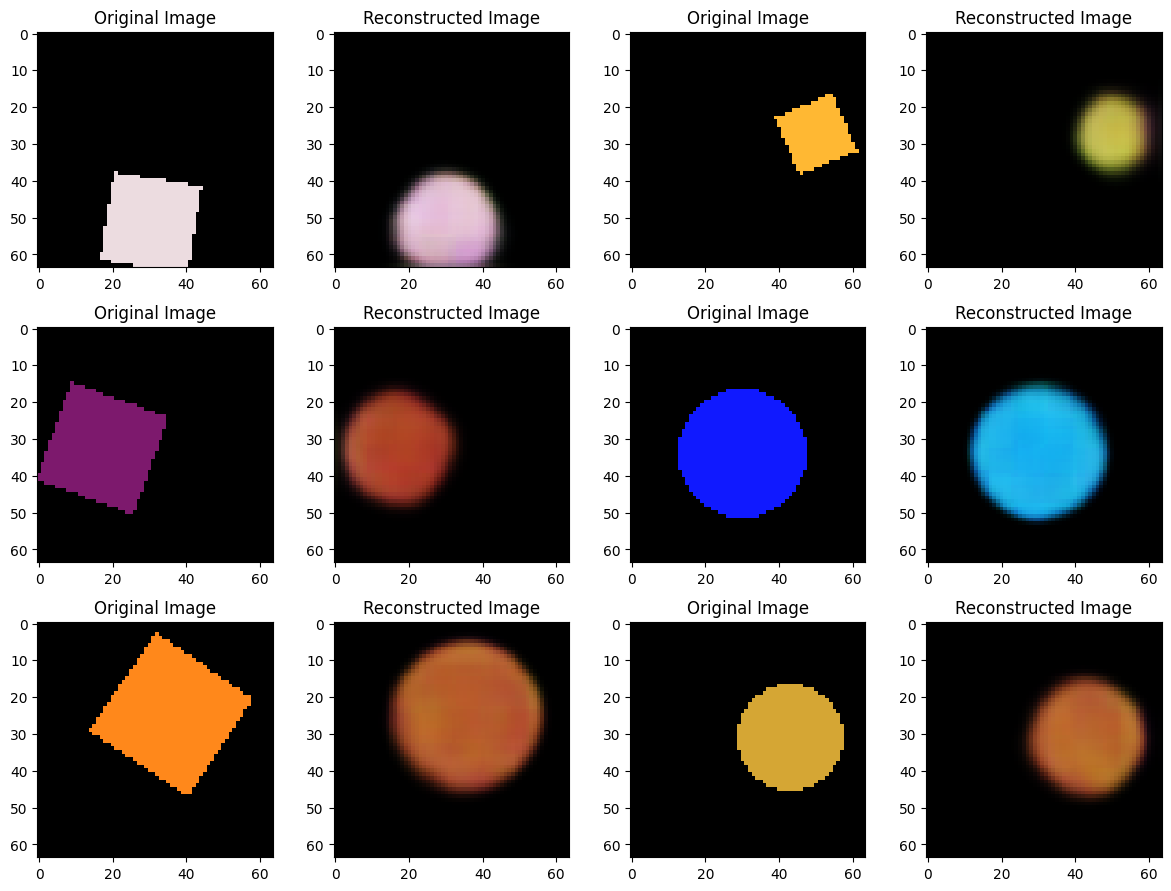

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): Dropout(p=0.1, inplace=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Dropout(p=0.1, inplace=False)
     (6): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 898155
Epoch [1/20], Train Loss: 0.2525, Test Loss: 0.1552
Epoch [2/20], Train Loss: 0.1423, Test Loss: 0.1435
Epoch [3/20], Train Loss: 0.1335, Test Loss: 0.1375
Epoch [4/20], Train Loss: 0.1211, Test Loss: 0.1218
Epoch [5/20], Train Loss: 0.1115, Test Loss: 0.1180
Epoch [6/20], Train Loss: 0.1068, Test Loss: 0.1149
Epoch [7/20], Train Loss: 0.1035, Test Loss: 0.1097
Epoch [8/20], Train Loss: 0.1005, Test Loss: 0.1153
Epoch [9/20], Train Loss: 0.0980, Test Loss: 0.1072
Epoch [10/20], Train Loss: 0.0962, Test Loss: 0.1051
Epoch [11/20], Train Loss: 0.0949, Test Loss: 0.1025
Epoch [12/20], Train Loss: 0.0935, Test Loss: 0.1028
Epoch [13/20], Train Loss: 0.0923, Test Loss: 0.1017
Epoch [14/20], Train Loss: 0.0912, Test Loss: 0.0995
Epoch [15/20], Train Loss: 0.0905, Test Loss: 0.0991
Epoch [16/20], Train Loss: 0.0900, Test Loss: 0.0976
Epoch [17/20], Train Loss: 0.0896, Test Loss: 0.0974
Epoch [18/20], Train Loss: 0.0893, Test Loss: 0.0976
Epoch [19/20], Train Loss:

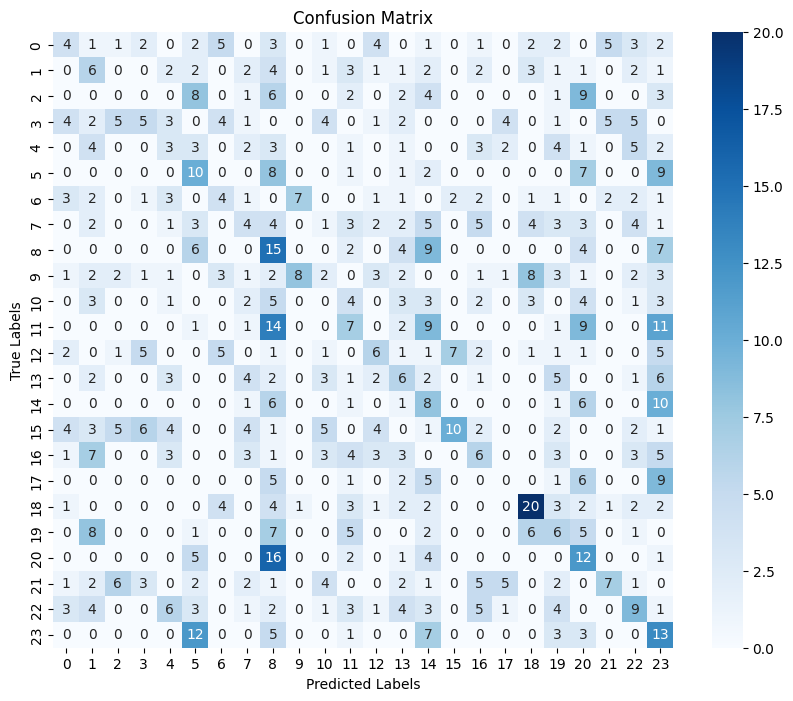

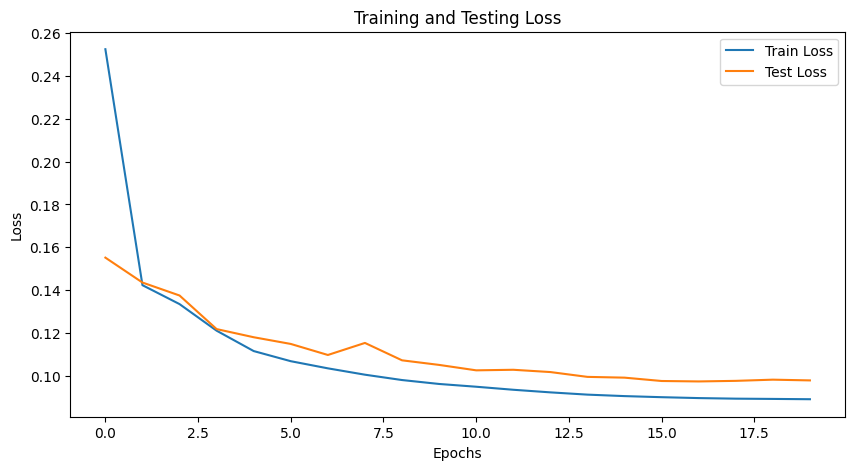

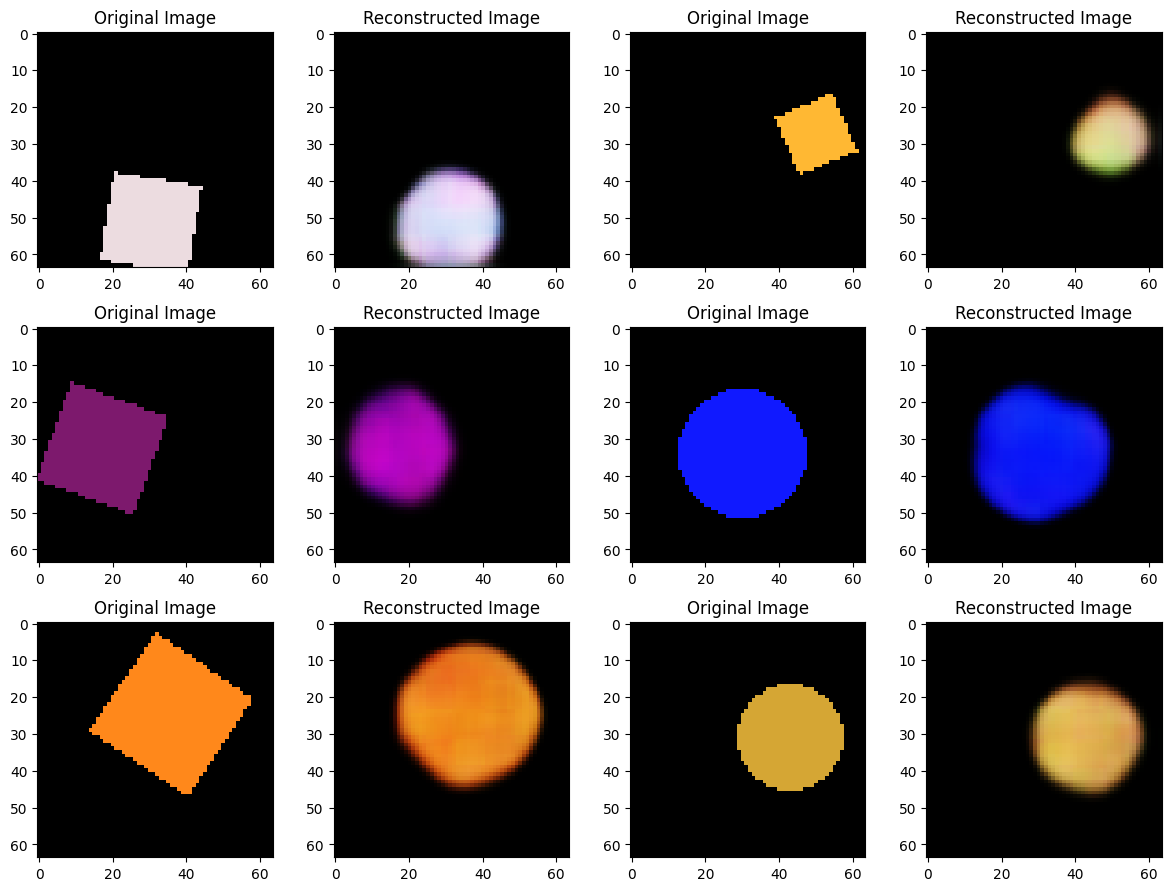

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): Dropout(p=0.1, inplace=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Dropout(p=0.1, inplace=False)
     (6): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 1029235
Epoch [1/20], Train Loss: 0.2229, Test Loss: 0.1488
Epoch [2/20], Train Loss: 0.1367, Test Loss: 0.1433
Epoch [3/20], Train Loss: 0.1200, Test Loss: 0.1177
Epoch [4/20], Train Loss: 0.1071, Test Loss: 0.1134
Epoch [5/20], Train Loss: 0.1010, Test Loss: 0.1070
Epoch [6/20], Train Loss: 0.0954, Test Loss: 0.0977
Epoch [7/20], Train Loss: 0.0910, Test Loss: 0.0940
Epoch [8/20], Train Loss: 0.0885, Test Loss: 0.0924
Epoch [9/20], Train Loss: 0.0870, Test Loss: 0.0914
Epoch [10/20], Train Loss: 0.0857, Test Loss: 0.0890
Epoch [11/20], Train Loss: 0.0845, Test Loss: 0.0890
Epoch [12/20], Train Loss: 0.0836, Test Loss: 0.0875
Epoch [13/20], Train Loss: 0.0827, Test Loss: 0.0876
Epoch [14/20], Train Loss: 0.0819, Test Loss: 0.0859
Epoch [15/20], Train Loss: 0.0814, Test Loss: 0.0861
Epoch [16/20], Train Loss: 0.0809, Test Loss: 0.0861
Epoch [17/20], Train Loss: 0.0807, Test Loss: 0.0855
Epoch [18/20], Train Loss: 0.0804, Test Loss: 0.0849
Epoch [19/20], Train Loss

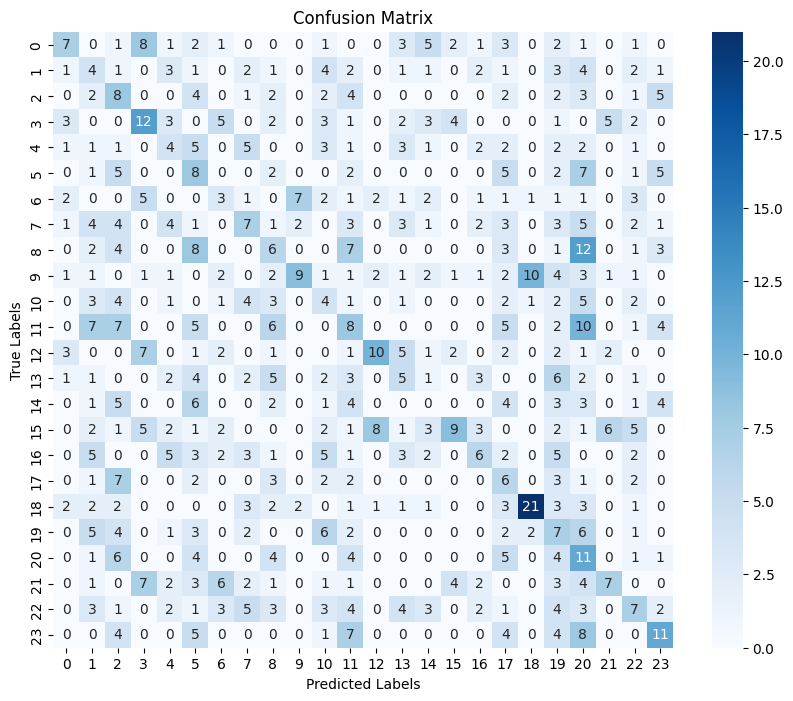

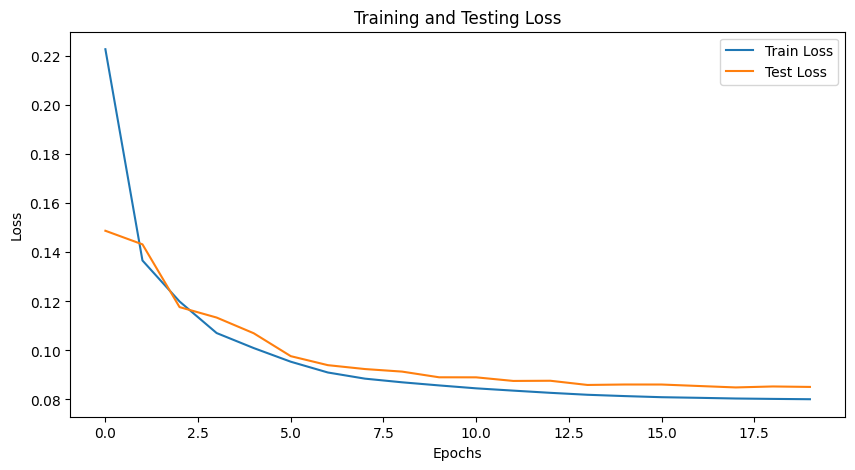

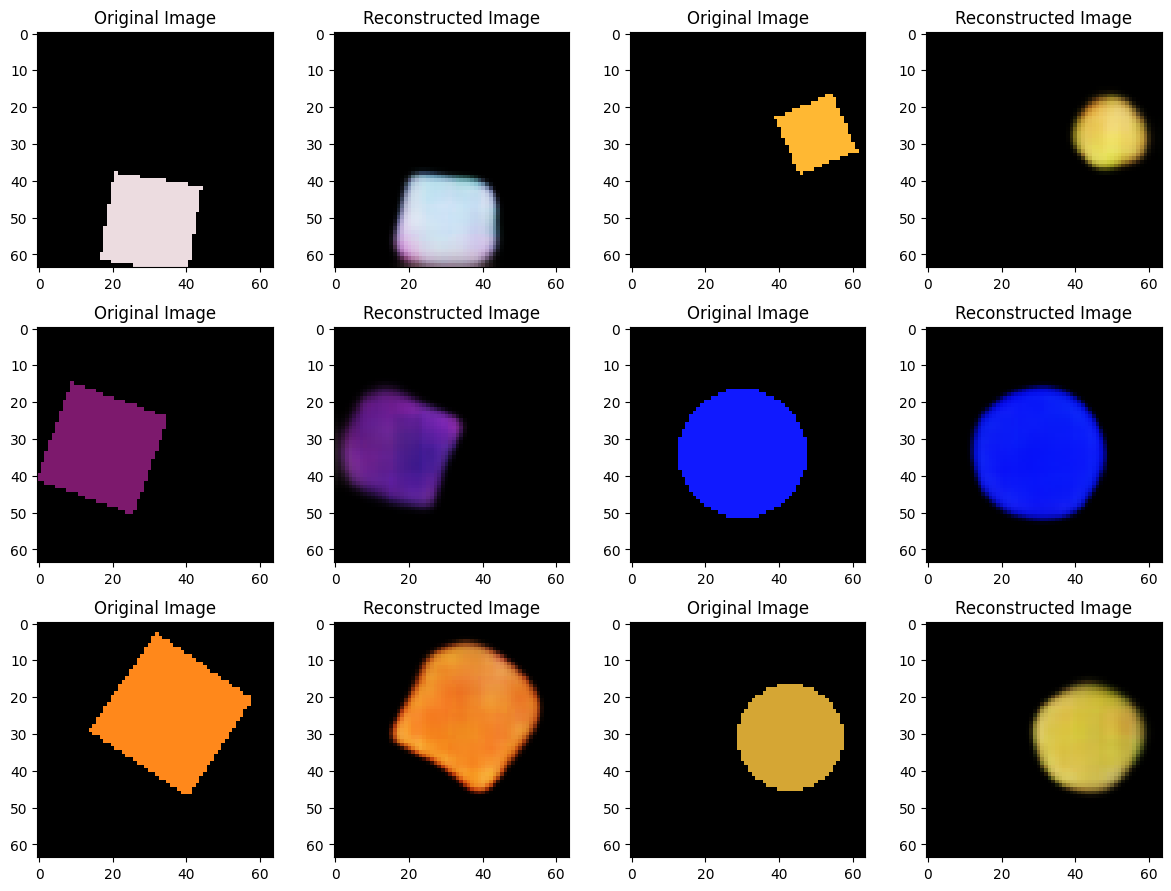

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): Dropout(p=0.1, inplace=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Dropout(p=0.1, inplace=False)
     (6): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 1291395
Epoch [1/20], Train Loss: 0.2157, Test Loss: 0.1469
Epoch [2/20], Train Loss: 0.1335, Test Loss: 0.1287
Epoch [3/20], Train Loss: 0.1136, Test Loss: 0.1114
Epoch [4/20], Train Loss: 0.1040, Test Loss: 0.1077
Epoch [5/20], Train Loss: 0.0978, Test Loss: 0.1004
Epoch [6/20], Train Loss: 0.0910, Test Loss: 0.0917
Epoch [7/20], Train Loss: 0.0865, Test Loss: 0.0898
Epoch [8/20], Train Loss: 0.0843, Test Loss: 0.0881
Epoch [9/20], Train Loss: 0.0825, Test Loss: 0.0855
Epoch [10/20], Train Loss: 0.0813, Test Loss: 0.0843
Epoch [11/20], Train Loss: 0.0803, Test Loss: 0.0834
Epoch [12/20], Train Loss: 0.0790, Test Loss: 0.0821
Epoch [13/20], Train Loss: 0.0784, Test Loss: 0.0810
Epoch [14/20], Train Loss: 0.0776, Test Loss: 0.0805
Epoch [15/20], Train Loss: 0.0772, Test Loss: 0.0806
Epoch [16/20], Train Loss: 0.0768, Test Loss: 0.0797
Epoch [17/20], Train Loss: 0.0765, Test Loss: 0.0794
Epoch [18/20], Train Loss: 0.0762, Test Loss: 0.0788
Epoch [19/20], Train Loss

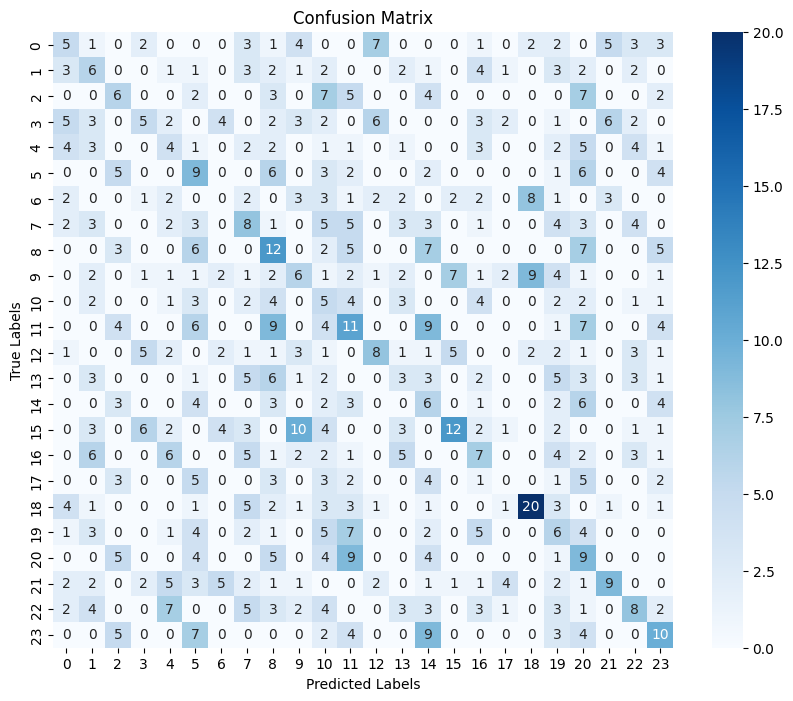

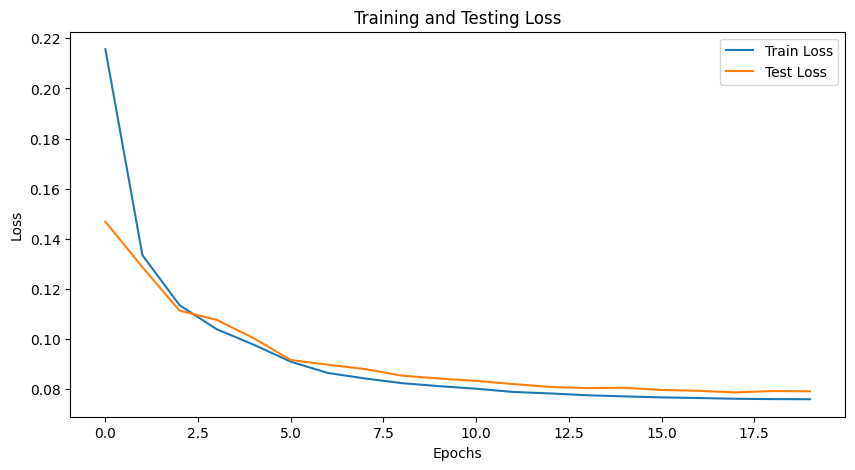

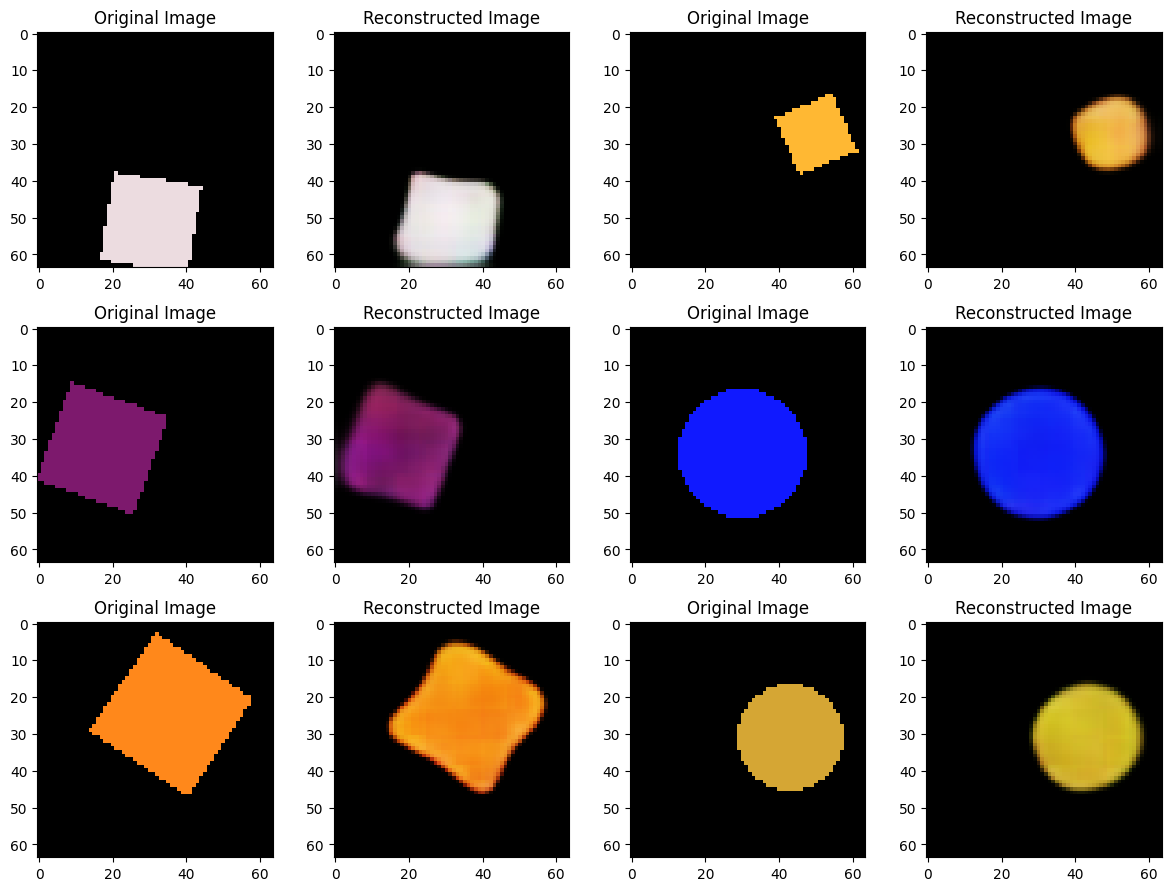

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): Dropout(p=0.1, inplace=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Dropout(p=0.1, inplace=False)
     (6): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 1815715
Epoch [1/20], Train Loss: 0.2098, Test Loss: 0.1464
Epoch [2/20], Train Loss: 0.1327, Test Loss: 0.1321
Epoch [3/20], Train Loss: 0.1136, Test Loss: 0.1101
Epoch [4/20], Train Loss: 0.1012, Test Loss: 0.0998
Epoch [5/20], Train Loss: 0.0906, Test Loss: 0.0905
Epoch [6/20], Train Loss: 0.0845, Test Loss: 0.0865
Epoch [7/20], Train Loss: 0.0821, Test Loss: 0.0839
Epoch [8/20], Train Loss: 0.0805, Test Loss: 0.0822
Epoch [9/20], Train Loss: 0.0787, Test Loss: 0.0799
Epoch [10/20], Train Loss: 0.0778, Test Loss: 0.0793
Epoch [11/20], Train Loss: 0.0769, Test Loss: 0.0792
Epoch [12/20], Train Loss: 0.0761, Test Loss: 0.0785
Epoch [13/20], Train Loss: 0.0756, Test Loss: 0.0775
Epoch [14/20], Train Loss: 0.0750, Test Loss: 0.0771
Epoch [15/20], Train Loss: 0.0746, Test Loss: 0.0770
Epoch [16/20], Train Loss: 0.0742, Test Loss: 0.0766
Epoch [17/20], Train Loss: 0.0740, Test Loss: 0.0766
Epoch [18/20], Train Loss: 0.0739, Test Loss: 0.0763
Epoch [19/20], Train Loss

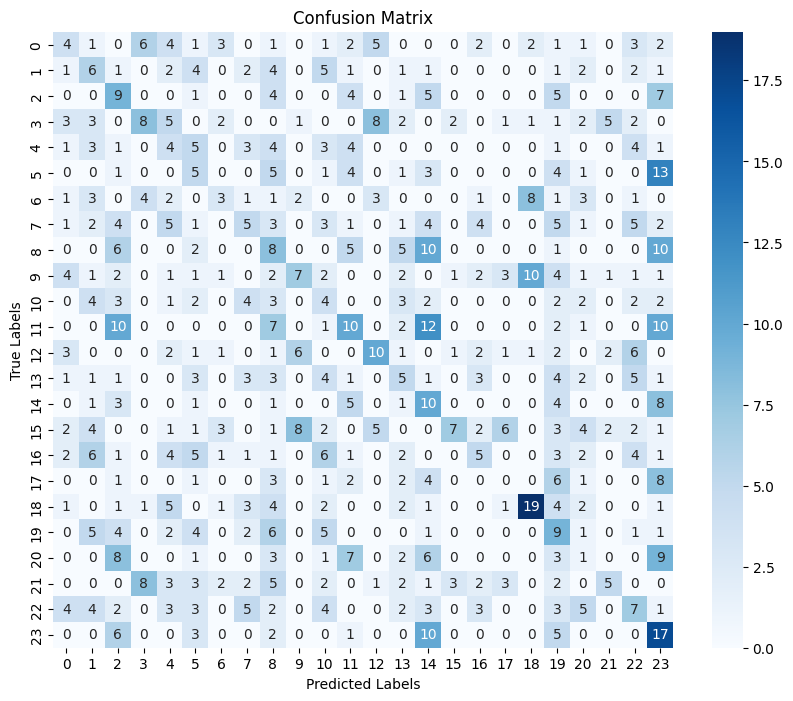

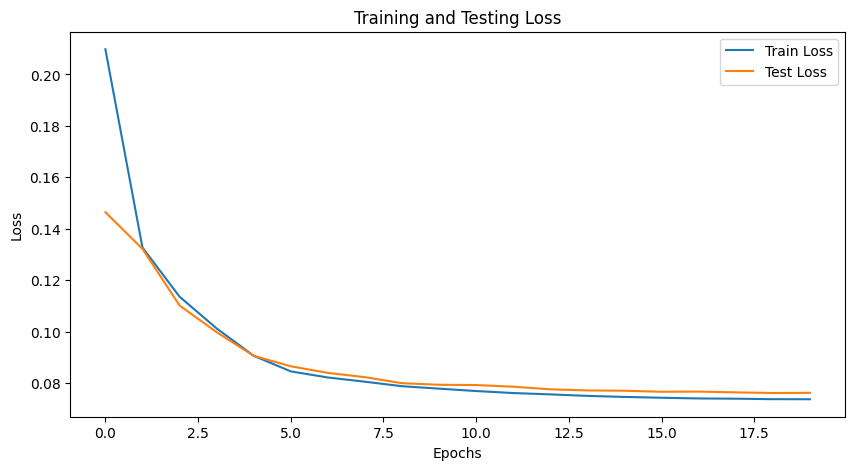

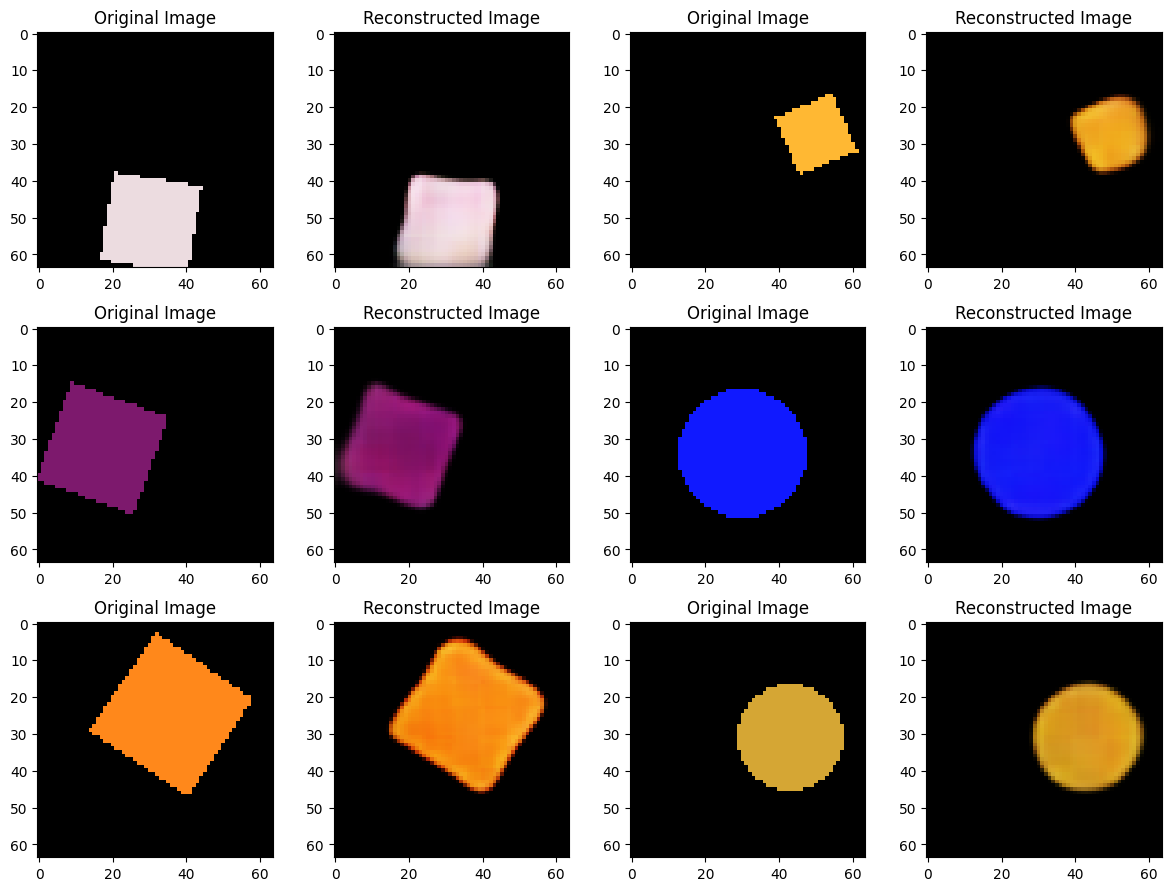

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): Dropout(p=0.1, inplace=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Dropout(p=0.1, inplace=False)
     (6): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)